<a href="https://colab.research.google.com/github/JemPak/Clasificacion_de_imagenes/blob/main/imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# El conjunto de datos incluye estas imágenes

`<userid> <pose> <expression> <eyes> <scale>.pgm`  
`<userid>` es la identificación del usuario de la persona en la imagen, y este campo tiene 20 valores: an2i, at33, boland, bpm, ch4f, cheyer, choon, danieln, glickman, karyadi, kawamura, kk49, megak, mitchell, night, phoebe, saavik, steffi, sz24 y tammo.  
`<pose>` es la posición de la cabeza de la persona, y este campo tiene 4 valores: straight (recto), left (izquierda), right (derecha), up (arriba).  
`<expression>` es la expresión facial de la persona, y este campo tiene 4 valores: neutral, happy (feliz), sad (triste), angry (enojado).  
`<eyes>` es el estado de los ojos de la persona, y este campo tiene 2 valores: open (abiertos), sunglasses (gafas de sol).  
`<scale>` es la escala de la imagen, y este campo tiene 3 valores: 1, 2 y 4.   
1 indica una imagen de resolución completa (128 columnas por 120 filas); 2 indica una imagen de resolución media (64 por 60); 4 indica una imagen de resolución cuarto (32 por 30).  

Si has estado observando de cerca en los directorios de imágenes, podrías notar que algunas imágenes tienen el sufijo .bad en lugar del sufijo .pgm. Resulta que 16 de las 640 imágenes tomadas tienen fallas debido a problemas con la configuración de la cámara; estas son las imágenes .bad. Algunas personas tuvieron más problemas que otras, pero todos los que fueron "faced" deberían tener al menos 28 buenas imágenes faciales (de las 32 variaciones posibles, excluyendo la escala).


**Nombre de los integrantes:**

\

* **Integrante 1:** Juan José Monsalve Patiño \\
* **Integrante 2:** Pamela Escobar Palacios \\
* **Integrante 3:** José Julián Aguirre Ramírez \\
* **Integrante 4:** Santiago Mejia Carmona


<center>
    <img src="https://blogs.elespectador.com/wp-content/uploads/2017/09/logo-Universidad-Nacional.png" width="500" alt="logo" />
</center>

**Definición del problema**

En el contexto del conjunto de datos CMU Face Images Data Set del UCI Machine Learning Repository, se presenta el desafío de construir y validar un modelo de aprendizaje estadístico capaz de clasificar imágenes de sujetos según la presencia o ausencia de gafas.

El conjunto de datos consta de 640 imágenes que representan a diversos sujetos en diferentes posiciones y expresiones faciales. Cada imagen está etiquetada con información detallada, incluyendo la identificación del usuario, la posición de la cabeza, la expresión facial, el estado de los ojos (gafas o no) y la escala de la imagen.

**Objetivo**

El objetivo principal es desarrollar un modelo predictivo que pueda analizar las imágenes y predecir si el sujeto lleva gafas o no. Esto implica la clasificación binaria de las imágenes en dos categorías: "con gafas" y "sin gafas". Se espera que el modelo pueda generalizar correctamente a nuevas imágenes no vistas durante el entrenamiento.

## Instalar librerias necesarias

In [3]:
from keras.utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import os
import seaborn as sns
from skimage import feature, io
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
import random
import itertools
from shutil import copyfile, rmtree
from pathlib import Path
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow_hub as hub
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import shutil
from sklearn.metrics import confusion_matrix

# Análisis descriptivo y exploratorio:

In [8]:
sin_gafas = 'imagenes_analitica/con_gafas'
con_gafas = 'imagenes_analitica/sin_gafas'
print('Se cuentan con', len(os.listdir(sin_gafas)), 'sin gafas')
print('--------------------------------------------------------------')
print('Se cuentan con', len(os.listdir(con_gafas)), 'con gafas')

Se cuentan con 312 sin gafas
--------------------------------------------------------------
Se cuentan con 313 con gafas


#Cargar y Preprocesar Imágenes

In [7]:
import os
from skimage import io, transform
import numpy as np
from sklearn.model_selection import train_test_split

# Directorio que contiene las carpetas con gafas y sin gafas
dataset_dir = 'imagenes_analitica'

# Cargar imágenes y etiquetas
X = []
y = []

for label, category in enumerate(['con_gafas', 'sin_gafas']):
    category_dir = os.path.join(dataset_dir, category)
    for filename in os.listdir(category_dir):
        img_path = os.path.join(category_dir, filename)
        if os.path.isfile(img_path):  # Aseguramos de que es un archivo
            img = io.imread(img_path)
            img = transform.resize(img, (64, 64, 3)).flatten()  # Ajusta el tamaño según sea necesario
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Se muestran algunas imagenes del conjunto de datos

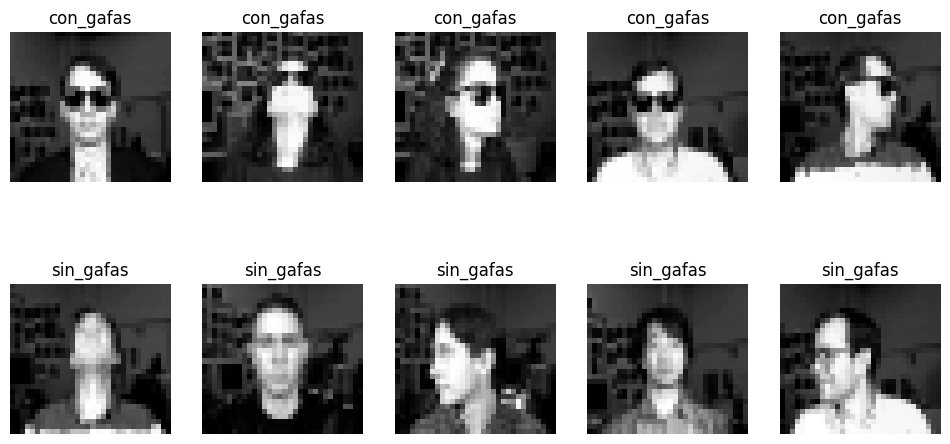

In [11]:
import matplotlib.pyplot as plt

# Visualizar algunas imágenes de cada clase
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for label, category in enumerate(['con_gafas', 'sin_gafas']):
    category_dir = os.path.join(dataset_dir, category)
    image_files = os.listdir(category_dir)[:5]  # Tomar las primeras 5 imágenes

    for i, filename in enumerate(image_files):
        img_path = os.path.join(category_dir, filename)
        img = io.imread(img_path)

        # Mostrar la imagen en la posición correspondiente en blanco y negro
        axes[label, i].imshow(img, cmap='gray')
        axes[label, i].set_title(category)
        axes[label, i].axis('off')

plt.show()

##Construir y Entrenar el Modelo

In [15]:
from tensorflow.keras import layers, models

# las imágenes son en escala de grises y aplanadas (64x64x3)
model = models.Sequential([
    layers.Dense(4096, activation='relu', input_shape=(64*64*3,)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
16/16 [==============================] - 21s 1s/step - loss: 7.5401 - accuracy: 0.5110 - val_loss: 4.0820 - val_accuracy: 0.5680
Epoch 2/10
16/16 [==============================] - 16s 987ms/step - loss: 2.4817 - accuracy: 0.5872 - val_loss: 1.8785 - val_accuracy: 0.5600
Epoch 3/10
16/16 [==============================] - 15s 971ms/step - loss: 2.3656 - accuracy: 0.6172 - val_loss: 2.0591 - val_accuracy: 0.5840
Epoch 4/10
16/16 [==============================] - 15s 946ms/step - loss: 1.1818 - accuracy: 0.7034 - val_loss: 1.2713 - val_accuracy: 0.6800
Epoch 5/10
16/16 [==============================] - 15s 980ms/step - loss: 1.0756 - accuracy: 0.7234 - val_loss: 0.6088 - val_accuracy: 0.7520
Epoch 6/10
16/16 [==============================] - 15s 959ms/step - loss: 0.8018 - accuracy: 0.7735 - val_loss: 0.7869 - val_accuracy: 0.7120
Epoch 7/10
16/16 [==============================] - 15s 968ms/step - loss: 0.7855 - accuracy: 0.7575 - val_loss: 0.5425 - val_accuracy: 0.7760
Ep

# Pruebas del Modelo

In [16]:
# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones a clases binarias (0 o 1) según un umbral (por ejemplo, 0.5)
threshold = 0.5
predicted_classes = (predictions > threshold).astype(int)

# Evaluar el rendimiento del modelo
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predicted_classes)
report = classification_report(y_test, predicted_classes)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

4/4 [==============================] - 1s 173ms/step
Accuracy: 0.808
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        71
           1       0.81      0.72      0.76        54

    accuracy                           0.81       125
   macro avg       0.81      0.80      0.80       125
weighted avg       0.81      0.81      0.81       125



# Precisión, recall y F1-score

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calcular precisión, recall y F1-score
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Calcular el área bajo la curva ROC
roc_auc = roc_auc_score(y_test, predictions)
print(f'Área bajo la curva ROC: {roc_auc}')


Precision: 0.8125
Recall: 0.7222222222222222
F1-score: 0.7647058823529411
Área bajo la curva ROC: 0.9003651538862807


# Matriz de Confusión

<Figure size 800x600 with 0 Axes>

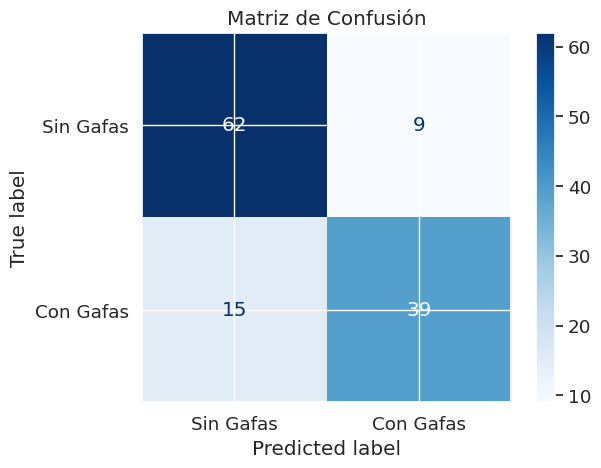

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted_classes)
sns.set(font_scale=1.2)  # Ajusta el tamaño de la fuente
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sin Gafas', 'Con Gafas']).plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

# Curva de Precisión-Recall

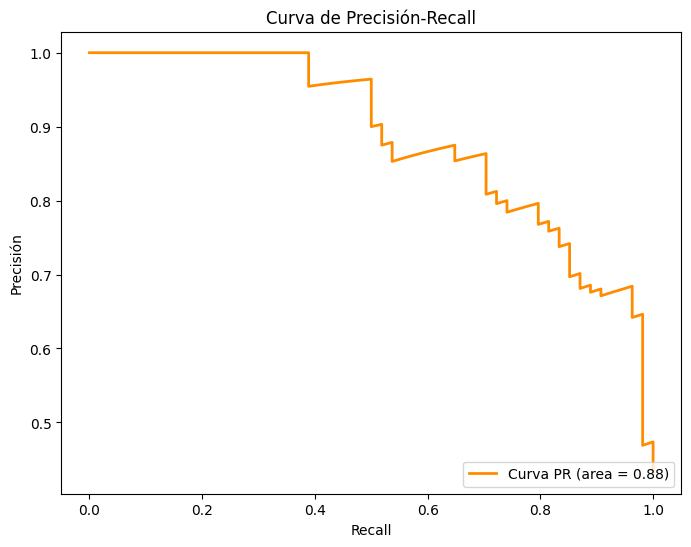

In [20]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
area_under_curve = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='Curva PR (area = {:.2f})'.format(area_under_curve))
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall')
plt.legend(loc='lower right')
plt.show()

# Curva ROC

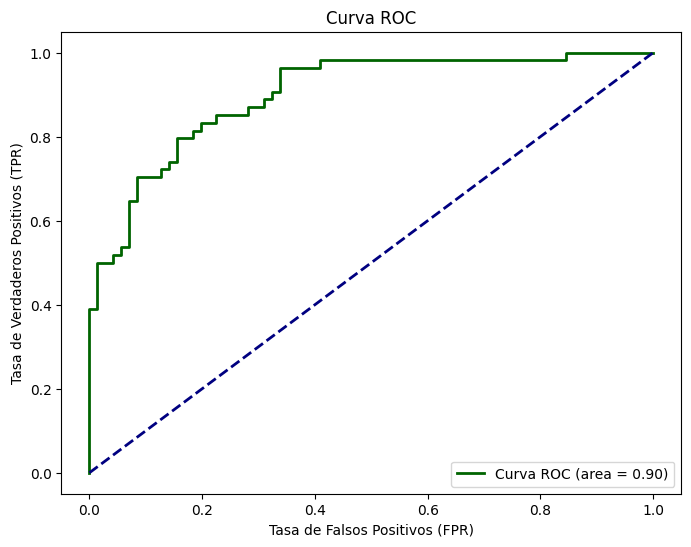

In [22]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()